# ✨Introduction 
Credits: https://www.kaggle.com/code/benroshan/transaction-fraud-detection#%F0%9F%A7%AA-Evaluation-of-model

In [1]:
#Basic libraries
import pandas as pd
import numpy as np

#preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
#ML libraries
#import tensorflow as tf

In [3]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

In [4]:
#Metrics Libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#Misc libraries
import warnings
warnings.filterwarnings("ignore")

### Dataset

In [5]:
raw_data = "../data/raw/paysim-dev.csv"
paysim=pd.read_csv(raw_data)
paysim.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
1,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
2,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
3,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0
4,259,PAYMENT,915.13,C2002954533,0.00,0.00,M290849763,0.00,0.00,0,0


In [6]:
len(paysim)

21043

In [7]:
paysim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21043 entries, 0 to 21042
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            21043 non-null  int64  
 1   type            21043 non-null  object 
 2   amount          21043 non-null  float64
 3   nameOrig        21043 non-null  object 
 4   oldbalanceOrg   21043 non-null  float64
 5   newbalanceOrig  21043 non-null  float64
 6   nameDest        21043 non-null  object 
 7   oldbalanceDest  21043 non-null  float64
 8   newbalanceDest  21043 non-null  float64
 9   isFraud         21043 non-null  int64  
 10  isFlaggedFraud  21043 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 1.8+ MB


### Dataset description
1. step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
2. type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
3. amount - amount of the transaction in local currency.
4. nameOrig - customer who started the transaction
5. oldbalanceOrg - initial balance before the transaction
6. newbalanceOrig - new balance after the transaction
7. nameDest - customer who is the recipient of the transaction
8. oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
9. newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
10. isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
11. isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

<div class="alert alert-block alert-info">
<b>🔍Inference:</b> <br>
As per the current rule based algorithm, there has been no flags during fraud transactions incase of cash_out , which a serious concern to the anti money laundering system . Also there are only 16 transactions which are flagged as fraud whereas around 4k transactions are actually fraud. Our mission is now to build an efficient algorithm to mitigate this risk of letting fraud transactions unblocked<br>
<br>   
</div>

<div class="alert alert-block alert-info">
<b>🔍Inference:</b> <br>
From the table we can understand that most of the customers use the system for transfering money and we have a relatively less data for payments made. Also it is quite interesting to notice the difference between the new and old balance as it tells us some stories. Here we have only the visuals of Orgin account and cash balance have reduced in all cases except cash_in . Even in transfer the balance have reduced which shows that we have more sender information in Original account<br>
<br>   
</div>

<div class="alert alert-block alert-info">
<b>🔍Inference:</b> <br>
In this table we have the information of destination account , from the transfer information we can see the increase in new balance, hence this is the receiver's info. There is no payment amount available for Dest information.<br>
<br>   
</div>

<div class="alert alert-block alert-info">
<b>🔍Inference:</b> <br>
From the bar plot we can understand that we have a very right skewed dataset, there are a lot of outliers which goes upto 10M with a median of 33k. The upper bracket(75th percentile) counts upto 450k<br>
<br>   
</div>

# 🔧 Feature engineering 
>  Time to get our hands dirty with feature engineering. With the available information it is hard to train the model and get better results. Hence we move onto create new features by altering the existing features. In this we create three functions which creates a highly relevant feature for the domain
>
> 1. **Difference in balance:** It is an universal truth that the amount debited from senders account gets credited into the receivers account without any deviation in cents. But what if there is a deviation incase of the amount debited and credited. Some could be due to the charges levied by the service providers, yet we need to flag such unusual instances
> 2. **Surge indicator:** Also we have to trigger flag when large amount are involved in the transaction. From the distribution of amount we understood that we have a lot of outliers with high amount in transactions. Hence we consider the 75th percentile(450k) as our threshold and amount which is greater than 450k will be triggered as a flag
> 3. **Frequency indicator:** Here we flag the user and not the transaction. When there is a receiver who receives money from a lot of people, it could be a trigger as it can be for some illegal games of chance or luck. Hence it is flagged when there is a receiver who receives money for more than 20 times.
>4. **Merchant indicator:** The customer ids in receiver starts with 'M' which means that they are merchants and they obviously will have a lot of receiving transactions. So we also flag whenever there is a merchant receiver

In [8]:
#Tallying the balance
def balance_diff(data):
    '''balance_diff checks whether the money debited from sender has exactly credited to the receiver
       then it creates a new column which indicates 1 when there is a deviation else 0'''
    #Sender's balance
    orig_change=data['newbalanceOrig']-data['oldbalanceOrg']
    orig_change=orig_change.astype(int)
    for i in orig_change:
        if i<0:
            data['orig_txn_diff']=round(data['amount']+orig_change,2)
        else:
            data['orig_txn_diff']=round(data['amount']-orig_change,2)
    data['orig_txn_diff']=data['orig_txn_diff'].astype(int)
    data['orig_diff'] = [1 if n !=0 else 0 for n in data['orig_txn_diff']] 
    
    #Receiver's balance
    dest_change=data['newbalanceDest']-data['oldbalanceDest']
    dest_change=dest_change.astype(int)
    for i in dest_change:
        if i<0:
            data['dest_txn_diff']=round(data['amount']+dest_change,2)
        else:
            data['dest_txn_diff']=round(data['amount']-dest_change,2)
    data['dest_txn_diff']=data['dest_txn_diff'].astype(int)
    data['dest_diff'] = [1 if n !=0 else 0 for n in data['dest_txn_diff']] 
    
    data.drop(['orig_txn_diff','dest_txn_diff'],axis=1,inplace = True)
    
#Surge indicator
def surge_indicator(data):
    '''Creates a new column which has 1 if the transaction amount is greater than the threshold
    else it will be 0'''
    data['surge']=[1 if n>450000 else 0 for n in data['amount']]

#Frequency indicator
def frequency_receiver(data):
    '''Creates a new column which has 1 if the receiver receives money from many individuals
    else it will be 0'''
    data['freq_Dest']=data['nameDest'].map(data['nameDest'].value_counts())
    data['freq_dest']=[1 if n>20 else 0 for n in data['freq_Dest']]
    
    data.drop(['freq_Dest'],axis=1,inplace = True)

#Tracking the receiver as merchant or not
def merchant(data):
    '''We also have customer ids which starts with M in Receiver name, it indicates merchant
    this function will flag if there is a merchant in receiver end '''
    values = ['M']
    conditions = list(map(data['nameDest'].str.contains, values))
    data['merchant'] = np.select(conditions, '1', '0')

In [9]:
#Applying balance_diff function
#balance_diff(paysim)

#paysim['orig_diff'].value_counts()
#paysim['dest_diff'].value_counts()

In [10]:
#Applying surge_indicator function
#surge_indicator(paysim)
#paysim['surge'].value_counts()

In [11]:
#Applying frequency_receiver function
#frequency_receiver(paysim)
#paysim['freq_dest'].value_counts()

# ⚙️ Pre-processing data
>  Before moving to build a machine learning model, it is mandatory to pre-process the data so that the model trains without any error and can learn better to provide better results

## 1. Train-test split 

In [12]:
paysim_1=paysim.copy()
x=paysim_1.drop('isFraud',axis=1)
y=paysim_1['isFraud']

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=111)

## 2. Balancing the target
> From the pie chart below we can clearly see that the target label is heavily imbalance as we have only 0.2% of fraudulent data which is in-sufficient for machine to learn and flag when fraud transactions happen.

In [13]:
# Function to balance classes in training data
from sklearn.utils import resample

def balance_classes(x_train, y_train, random_state=123):
    """Upsample the minority class in x_train/y_train to match the majority class size."""
    train_balanced = x_train.copy()
    train_balanced['isFraud'] = y_train.values
    majority_class = train_balanced['isFraud'].value_counts().idxmax()
    minority_class = train_balanced['isFraud'].value_counts().idxmin()
    df_majority = train_balanced[train_balanced['isFraud'] == majority_class]
    df_minority = train_balanced[train_balanced['isFraud'] == minority_class]
    df_minority_upsampled = resample(df_minority, 
                                 replace=True, 
                                 n_samples=len(df_majority), 
                                 random_state=random_state)
    train_balanced = pd.concat([df_majority, df_minority_upsampled])
    train_balanced = train_balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)
    x_train_bal = train_balanced.drop('isFraud', axis=1)
    y_train_bal = train_balanced['isFraud']
    return x_train_bal, y_train_bal

# Apply balancing to x_train and y_train
x_train, y_train = balance_classes(x_train, y_train)

## 3. One hot encoding
> One of the most important feature we have is type which is categorical in type. Since it doesnt have any ordinal nature and since the classes are less, we prefer applying one hot encoding. 

In [14]:
# One hot encoding for 'type' column in x_train and x_test
""" 
for df in [x_train, x_test]:
    if 'type' in df.columns:
        dummies = pd.get_dummies(df['type'], prefix='type_')
        df.drop(['type'], axis=1, inplace=True)
        df[dummies.columns] = dummies
 """
# Ensure both x_train and x_test have the same columns after encoding
#x_train, x_test = x_train.align(x_test, join='left', axis=1, fill_value=0)

" \nfor df in [x_train, x_test]:\n    if 'type' in df.columns:\n        dummies = pd.get_dummies(df['type'], prefix='type_')\n        df.drop(['type'], axis=1, inplace=True)\n        df[dummies.columns] = dummies\n "

In [15]:

def one_hot_encode_and_align(x_train, x_test, column):
    # One-hot encode the specified column in both train and test
    for df in [x_train, x_test]:
        if column in df.columns:
            dummies = pd.get_dummies(df[column], prefix=f"{column}_")
            df.drop([column], axis=1, inplace=True)
            df[dummies.columns] = dummies
    # Align columns to ensure both have the same features
    x_train, x_test = x_train.align(x_test, join='left', axis=1, fill_value=0)
    return x_train, x_test

x_train, x_test = one_hot_encode_and_align(x_train, x_test, "type")

## 4.Standardize
> In this module we create the independent and dependent feature, then split them into train and test data where training size is 70%. Later we collect all the numerical features and apply StandardScaler() function which transforms the distribution so that the mean becomes 0 and standard deviation becomes 1 

In [16]:
# Standardizing the numerical columns in x_train and x_test only
"""
col_names = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
features_train = x_train[col_names]
features_test = x_test[col_names]

scaler = StandardScaler().fit(features_train.values)

features_train = scaler.transform(features_train.values)
features_test = scaler.transform(features_test.values)

x_train[col_names] = features_train
x_test[col_names] = features_test
"""

"\ncol_names = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']\nfeatures_train = x_train[col_names]\nfeatures_test = x_test[col_names]\n\nscaler = StandardScaler().fit(features_train.values)\n\nfeatures_train = scaler.transform(features_train.values)\nfeatures_test = scaler.transform(features_test.values)\n\nx_train[col_names] = features_train\nx_test[col_names] = features_test\n"

In [17]:
from sklearn.preprocessing import StandardScaler

def standardize_columns(x_train, x_test, col_names):
    scaler = StandardScaler().fit(x_train[col_names].values)
    x_train[col_names] = scaler.transform(x_train[col_names].values)
    x_test[col_names] = scaler.transform(x_test[col_names].values)
    return x_train, x_test

col_names = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
x_train, x_test = standardize_columns(x_train, x_test, col_names)

## 5. Tokenization
> We had the customer ids and merchant ids stored in object type. It is bad to apply one hot encoding in it as it can lead to more features and curse of dimensionality can incur. Hence we are applying tokenization here as it can create an unique id number which is in 'int' type for each customer id

In [18]:
# import tensorflow as tf

In [19]:
#Tokenzation of customer name to get a unique id
""" 
tokenizer_org = tf.keras.preprocessing.text.Tokenizer()
tokenizer_org.fit_on_texts(x_train['nameOrig'])

tokenizer_dest = tf.keras.preprocessing.text.Tokenizer()
tokenizer_dest.fit_on_texts(x_train['nameDest'])

# Create tokenized customer lists
customers_train_org = tokenizer_org.texts_to_sequences(x_train['nameOrig'])
customers_test_org = tokenizer_org.texts_to_sequences(x_test['nameOrig'])

customers_train_dest = tokenizer_dest.texts_to_sequences(x_train['nameDest'])
customers_test_dest = tokenizer_dest.texts_to_sequences(x_test['nameDest'])


# Pad sequences
x_train['customers_org'] = tf.keras.preprocessing.sequence.pad_sequences(customers_train_org, maxlen=1)
x_test['customers_org'] = tf.keras.preprocessing.sequence.pad_sequences(customers_test_org, maxlen=1)

x_train['customers_dest'] = tf.keras.preprocessing.sequence.pad_sequences(customers_train_dest, maxlen=1)
x_test['customers_dest'] = tf.keras.preprocessing.sequence.pad_sequences(customers_test_dest, maxlen=1)
"""

" \ntokenizer_org = tf.keras.preprocessing.text.Tokenizer()\ntokenizer_org.fit_on_texts(x_train['nameOrig'])\n\ntokenizer_dest = tf.keras.preprocessing.text.Tokenizer()\ntokenizer_dest.fit_on_texts(x_train['nameDest'])\n\n# Create tokenized customer lists\ncustomers_train_org = tokenizer_org.texts_to_sequences(x_train['nameOrig'])\ncustomers_test_org = tokenizer_org.texts_to_sequences(x_test['nameOrig'])\n\ncustomers_train_dest = tokenizer_dest.texts_to_sequences(x_train['nameDest'])\ncustomers_test_dest = tokenizer_dest.texts_to_sequences(x_test['nameDest'])\n\n\n# Pad sequences\nx_train['customers_org'] = tf.keras.preprocessing.sequence.pad_sequences(customers_train_org, maxlen=1)\nx_test['customers_org'] = tf.keras.preprocessing.sequence.pad_sequences(customers_test_org, maxlen=1)\n\nx_train['customers_dest'] = tf.keras.preprocessing.sequence.pad_sequences(customers_train_dest, maxlen=1)\nx_test['customers_dest'] = tf.keras.preprocessing.sequence.pad_sequences(customers_test_dest, m

In [20]:
# Alternative to TensorFlow tokenization: use pandas.factorize to convert IDs to unique integers
"""
x_train['customers_org'], org_uniques = pd.factorize(x_train['nameOrig'])
x_test['customers_org'] = org_uniques.get_indexer(x_test['nameOrig'])

x_train['customers_dest'], dest_uniques = pd.factorize(x_train['nameDest'])
x_test['customers_dest'] = dest_uniques.get_indexer(x_test['nameDest'])

# Any unknown IDs in test set will be encoded as -1. Can replace -1 with a new integer if needed, e.g.:
x_test['customers_org'] = x_test['customers_org'].replace(-1, len(org_uniques))
x_test['customers_dest'] = x_test['customers_dest'].replace(-1, len(dest_uniques))
"""

"\nx_train['customers_org'], org_uniques = pd.factorize(x_train['nameOrig'])\nx_test['customers_org'] = org_uniques.get_indexer(x_test['nameOrig'])\n\nx_train['customers_dest'], dest_uniques = pd.factorize(x_train['nameDest'])\nx_test['customers_dest'] = dest_uniques.get_indexer(x_test['nameDest'])\n\n# Any unknown IDs in test set will be encoded as -1. Can replace -1 with a new integer if needed, e.g.:\nx_test['customers_org'] = x_test['customers_org'].replace(-1, len(org_uniques))\nx_test['customers_dest'] = x_test['customers_dest'].replace(-1, len(dest_uniques))\n"

In [21]:
def tokenize_column(x_train, x_test, column):
    # Fit factorizer on x_train
    x_train[f"{column}_token"], uniques = pd.factorize(x_train[column])
    # Map test set using train uniques
    x_test[f"{column}_token"] = uniques.get_indexer(x_test[column])
    # Replace -1 (unknowns) with a new integer
    x_test[f"{column}_token"] = x_test[f"{column}_token"].replace(-1, len(uniques))
    return x_train, x_test

x_train, x_test = tokenize_column(x_train, x_test, "nameOrig")
x_train, x_test = tokenize_column(x_train, x_test, "nameDest")

### 6. Dropping unnecessary columns
> We dont need the sender and receiver id as we have tokenized them, also we dont required isFlaggedFraud as it is just an outcome of current algorithm. 

In [22]:
#Dropping unnecessary columns
x_train=x_train.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)
x_train = x_train.reset_index(drop=True)

x_test=x_test.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)
x_test = x_test.reset_index(drop=True)

In [23]:
x_test.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type__CASH_IN,type__CASH_OUT,type__DEBIT,type__PAYMENT,type__TRANSFER,nameOrig_token,nameDest_token
0,23,-0.406162,-0.349049,-0.209622,-0.089585,-0.133427,False,True,False,False,False,14730,14500
1,22,-0.445302,-0.405398,-0.245925,-0.354481,-0.403173,False,False,False,True,False,14730,14500
2,10,-0.423257,-0.409283,-0.248672,-0.318321,-0.344100,False,True,False,False,False,14730,14500
3,34,-0.285501,-0.409283,-0.248672,0.119416,0.291609,False,True,False,False,False,14730,14500
4,306,-0.316417,1.108936,1.534173,0.055351,-0.128637,True,False,False,False,False,14730,14500


# 🤖 Model Building
> We have successfully processed the data and it is time for serving the data to the model. It is time consuming to find out which model works best for our data. Hence I have utlized pipeline to run our data through all the classification algorithm and select the best which gives out the maximum accuracy.

In [31]:
#creating the objects
logreg_cv = LogisticRegression(solver='liblinear',random_state=123)
dt_cv=DecisionTreeClassifier(random_state=123)
#knn_cv=KNeighborsClassifier()
#svc_cv=SVC(kernel='linear',random_state=123)
nb_cv=GaussianNB()
rf_cv=RandomForestClassifier(random_state=123)
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes',5:'Random Forest'}
cv_models=[logreg_cv,dt_cv,nb_cv,rf_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, x_train, y_train, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.9251189666893269
Decision Tree Test Accuracy: 0.9740992522093814
KNN Test Accuracy: 0.9988103331067301
SVC Test Accuracy: 0.996057104010877
SVC Test Accuracy: 0.996057104010877


In [30]:
# Classification report for Logistic Regression
from sklearn.metrics import classification_report
logreg = LogisticRegression(solver='liblinear', random_state=123, class_weight='balanced')
logreg.fit(x_train, y_train)
y_pred_logreg = logreg.predict(x_test)
print(classification_report(y_test, y_pred_logreg, target_names=['Not Fraud','Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00      6308
       Fraud       0.00      0.00      0.00         5

    accuracy                           1.00      6313
   macro avg       0.50      0.50      0.50      6313
weighted avg       1.00      1.00      1.00      6313



<div class="alert alert-block alert-info">
<b>💭Thoughts:</b> <br>
We can see who won the prize-it is Naive Bayes. Other algorithms have also performed in par with NB especially Random Forest and KNN. It sure looks overfitted as the accuracy is near 100% which can be verified using the test data. Before that lets do hyperparameter tuning on NB<br>
<br>   
</div>

## ⛮ Hyperparameter Tuning
> Lets fit the Naive bayes model by tuning the model with its parameters. Here we are gonna tune var_smoothing which is a stability calculation to widen (or smooth) the curve and therefore account for more samples that are further away from the distribution mean. In this case, np.logspace returns numbers spaced evenly on a log scale, starts from 0, ends at -9, and generates 100 samples.

In [25]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(x_train, y_train)
print(nbModel_grid.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=np.float64(1e-09))
GaussianNB(var_smoothing=np.float64(1e-09))


# 🧪 Evaluation of model
> Time to explore the truth of high numbers by evaluating against testing data

In [26]:
#Function for Confusion matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


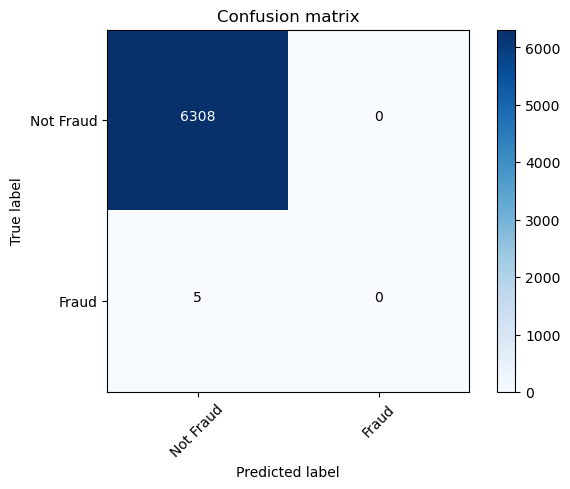

In [27]:
#Predict with the selected best parameter
y_pred=nbModel_grid.predict(x_test)

#Plotting confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Not Fraud','Fraud'])

<div class="alert alert-block alert-info">
<b>💭Thoughts:</b> <br>
The model has identified false positives but never let even a single false negative which is more important than FP. Since we cant miss out a fraud transactions, but we can manage false positive results by investigating them  <br>
<br>   
</div>

In [28]:
#Classification metrics
print(classification_report(y_test, y_pred, target_names=['Not Fraud','Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00      6308
       Fraud       0.00      0.00      0.00         5

    accuracy                           1.00      6313
   macro avg       0.50      0.50      0.50      6313
weighted avg       1.00      1.00      1.00      6313



### Show a sample input and the model's prediction for Naive Bayes

In [29]:
import pandas as pd
import numpy as np

# Select a random sample from the test set
sample_idx = 0  # Change this index to see other samples
sample_input = x_test.iloc[sample_idx]
sample_true_label = y_test.iloc[sample_idx]

# Reshape input for prediction
sample_input_reshaped = sample_input.values.reshape(1, -1)

# Model prediction
sample_pred_proba = nbModel_grid.predict_proba(sample_input_reshaped)[0, 1]
sample_pred_class = nbModel_grid.predict(sample_input_reshaped)[0]

print("Sample input features:\n", sample_input)
print(f"True label: {sample_true_label}")
print(f"Predicted probability of fraud: {sample_pred_proba:.4f}")
print(f"Predicted class: {sample_pred_class}")

Sample input features:
 step                    23
amount           -0.406162
oldbalanceOrg    -0.349049
newbalanceOrig   -0.209622
oldbalanceDest   -0.089585
newbalanceDest   -0.133427
type__CASH_IN        False
type__CASH_OUT        True
type__DEBIT          False
type__PAYMENT        False
type__TRANSFER       False
nameOrig_token       14730
nameDest_token       14500
Name: 0, dtype: object
True label: 0
Predicted probability of fraud: 0.0000
Predicted class: 0


<div class="alert alert-block alert-info">
<b>💭Thoughts:</b> <br>
When we found that our false negatives are more important than false positives, we have to look at the recall number and we have 100% recall in finding the fraud transactions and 100% precision in finding the non fraud tranactions and on an average our model performs more than 70% accurate which is pretty good and there are possible chance to improve the performance of this model.  <br>
<br>   
</div>